In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
train_path = '/content/drive/MyDrive/MedicalAI/image_data/skin_cancer/Train'
test_path = '/content/drive/MyDrive/MedicalAI/image_data/skin_cancer/Train'


In [4]:
# Get class names (folder names)
class_names = sorted(os.listdir(train_path))
num_classes = len(class_names)

# Create label mapping
label_map = {i: class_name for i, class_name in enumerate(class_names)}
print("Class mapping:")
for i, class_name in label_map.items():
    print(f"{i}: {class_name}")

Class mapping:
0: actinic keratosis
1: basal cell carcinoma
2: dermatofibroma
3: melanoma
4: nevus
5: not_skin_cancer
6: pigmented benign keratosis
7: seborrheic keratosis
8: squamous cell carcinoma
9: vascular lesion


In [5]:
# Create DataFrames for train and test
def create_dataframe(directory):
    data = []
    for class_label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.jpg'):
                image_path = os.path.join(class_dir, filename)
                data.append({'image_path': image_path, 'label': class_label})
    return pd.DataFrame(data)

train_df = create_dataframe(train_path)
test_df = create_dataframe(test_path)


In [6]:
# Combine for EDA
df = pd.concat([train_df, test_df], ignore_index=True)

print(f"\nTotal images: {len(df)}")
print(f"Number of classes: {num_classes}")
df.head()


Total images: 4664
Number of classes: 10


,image_path,label
0,/content/drive/MyDrive/MedicalAI/image_data/sk...,0
1,/content/drive/MyDrive/MedicalAI/image_data/sk...,0
2,/content/drive/MyDrive/MedicalAI/image_data/sk...,0
3,/content/drive/MyDrive/MedicalAI/image_data/sk...,0
4,/content/drive/MyDrive/MedicalAI/image_data/sk...,0


Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              228       
1               basal cell carcinoma           752       
2               dermatofibroma                 190       
3               melanoma                       876       
4               nevus                          714       
5               not_skin_cancer                186       
6               pigmented benign keratosis     924       
7               seborrheic keratosis           154       
8               squamous cell carcinoma        362       
9               vascular lesion                278       
------------------------------------------------------------
Total                                         4664      


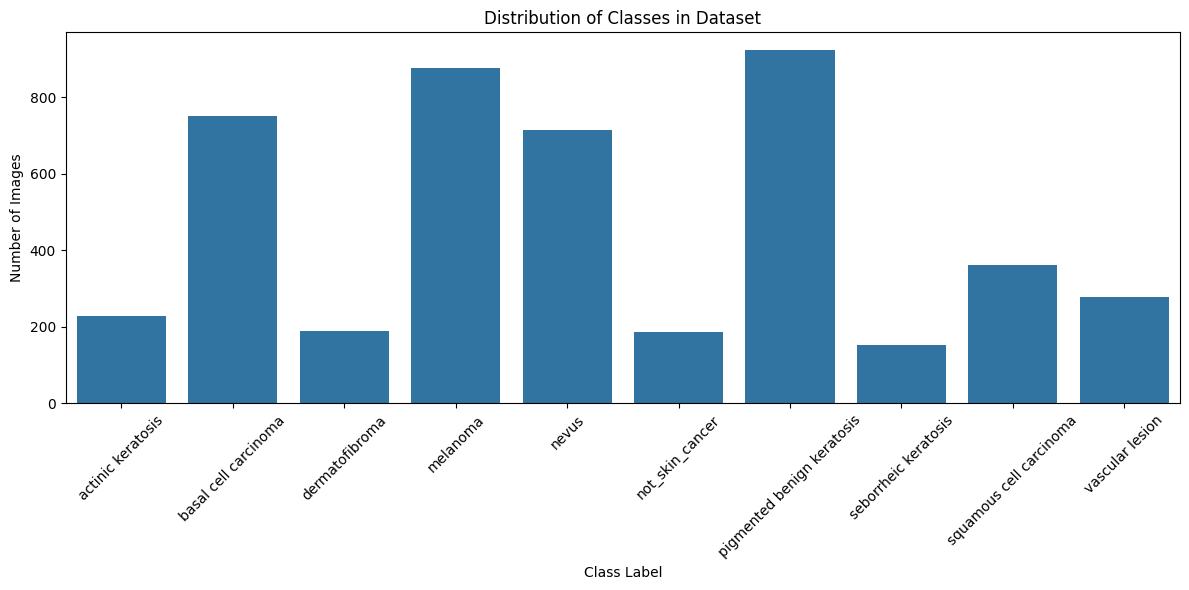

In [7]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

# Plot class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Classes in Dataset')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.xticks(ticks=range(num_classes), labels=[label_map[i] for i in range(num_classes)], rotation=45)
plt.tight_layout()
plt.show()

In [17]:
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample

# Define image size
IMG_HEIGHT = 75
IMG_WIDTH = 100

# Function to load and resize images
def load_and_resize_image(image_path):
    try:
        img = Image.open(image_path)

        # FORCE RGB (removes alpha channel if present)
        img = img.convert("RGB")

        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        return np.array(img)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

# Load all images
print("Loading images...")
df['image'] = df['image_path'].apply(load_and_resize_image)
df = df.dropna(subset=['image'])  # Remove failed loads
print(f"Successfully loaded {len(df)} images")

# Find the class with the maximum number of samples
max_class_size = df['label'].value_counts().max()
print(f"Majority class size: {max_class_size}")

# Create a balanced dataset by oversampling minority classes
balanced_dfs = []
for class_label in df['label'].unique():
    class_df = df[df['label'] == class_label]
    if len(class_df) < max_class_size:
        # Oversample minority classes
        oversampled_df = resample(class_df,
                                 replace=True,
                                 n_samples=max_class_size,
                                 random_state=42)
        balanced_dfs.append(oversampled_df)
    else:
        balanced_dfs.append(class_df)

# Combine balanced dataframes
balanced_df = pd.concat(balanced_dfs)
print(f"Balanced dataset size: {len(balanced_df)}")

# Verify new class distribution
print("\nBalanced Class Distribution:")
print(balanced_df['label'].value_counts().sort_index())

# Normalize pixel values
balanced_df['image'] = balanced_df['image'] / 255.0

# Create data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Loading images...
Successfully loaded 4664 images
Majority class size: 924
Balanced dataset size: 9240

Balanced Class Distribution:
label
0    924
1    924
2    924
3    924
4    924
5    924
6    924
7    924
8    924
9    924
Name: count, dtype: int64


In [18]:
shapes = balanced_df['image'].apply(lambda x: x.shape)
shapes.value_counts()


,count
image,
"(75, 100, 3)",9240


In [19]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Prepare data for splitting
x = np.stack(balanced_df['image'].values)
y = balanced_df['label'].values

# Convert labels to one-hot encoding
y_onehot = tf.keras.utils.to_categorical(y, num_classes=num_classes)

# Split into train (70%), validation (15%), and test (15%)
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y_onehot,
    test_size=0.3,
    stratify=y,
    random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp,
    test_size=0.5,
    stratify=np.argmax(y_temp, axis=1),
    random_state=42
)

# Print split information
print(f"Training set: {x_train.shape} - {len(y_train)} samples")
print(f"Validation set: {x_val.shape} - {len(y_val)} samples")
print(f"Test set: {x_test.shape} - {len(y_test)} samples")

# Verify class distribution in each split
def print_class_distribution(y_data, split_name):
    y_labels = np.argmax(y_data, axis=1)
    unique, counts = np.unique(y_labels, return_counts=True)
    print(f"\n{split_name} Class Distribution:")
    for label, count in zip(unique, counts):
        print(f"  Class {label} ({label_map[label]}): {count} samples")

print_class_distribution(y_train, "Training")
print_class_distribution(y_val, "Validation")
print_class_distribution(y_test, "Test")

Training set: (6468, 75, 100, 3) - 6468 samples
Validation set: (1386, 75, 100, 3) - 1386 samples
Test set: (1386, 75, 100, 3) - 1386 samples

Training Class Distribution:
  Class 0 (actinic keratosis): 647 samples
  Class 1 (basal cell carcinoma): 647 samples
  Class 2 (dermatofibroma): 647 samples
  Class 3 (melanoma): 646 samples
  Class 4 (nevus): 647 samples
  Class 5 (not_skin_cancer): 647 samples
  Class 6 (pigmented benign keratosis): 646 samples
  Class 7 (seborrheic keratosis): 647 samples
  Class 8 (squamous cell carcinoma): 647 samples
  Class 9 (vascular lesion): 647 samples

Validation Class Distribution:
  Class 0 (actinic keratosis): 139 samples
  Class 1 (basal cell carcinoma): 139 samples
  Class 2 (dermatofibroma): 138 samples
  Class 3 (melanoma): 139 samples
  Class 4 (nevus): 138 samples
  Class 5 (not_skin_cancer): 138 samples
  Class 6 (pigmented benign keratosis): 139 samples
  Class 7 (seborrheic keratosis): 139 samples
  Class 8 (squamous cell carcinoma): 138

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the model architecture
def create_model(input_shape=(75, 100, 3), num_classes=9):
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Fourth convolutional block
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Flatten and dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Create the model
model = create_model(input_shape=(75, 100, 3), num_classes=num_classes)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 10, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,444,554 (5.51 MB)

 Trainable params: 1,443,594 (5.51 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.3372 - loss: 2.6468
Epoch 1: val_accuracy improved from -inf to 0.11255, saving model to best_skin_cancer_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 157s 752ms/step - accuracy: 0.3376 - loss: 2.6438 - val_accuracy: 0.1126 - val_loss: 4.4798 - learning_rate: 0.0010
Epoch 2/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.5531 - loss: 1.2526
Epoch 2: val_accuracy improved from 0.11255 to 0.25758, saving model to best_skin_cancer_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 151s 745ms/step - accuracy: 0.5532 - loss: 1.2522 - val_accuracy: 0.2576 - val_loss: 3.6119 - learning_rate: 0.0010
Epoch 3/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.6457 - loss: 1.0032
Epoch 3: val_accuracy improved from 0.25758 to 0.44300, saving model to best_skin_cancer_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 152s 750ms/step - accuracy: 0.6459 - loss: 1.0029 - val_accuracy: 0.4430 - val_loss: 1.9385 - learning_rate: 0.0010
Epoch 4/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.7261 - loss: 0.7533
Epoch 4: val_accuracy improved from 0.44300 to 0.58081, saving model to best_skin_cancer_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 206s 768ms/step - accuracy: 0.7262 - loss: 0.7532 - val_accuracy: 0.5808 - val_loss: 1.0959 - learning_rate: 0.0010
Epoch 5/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.7817 - loss: 0.6314
Epoch 5: val_accuracy did not improve from 0.58081
203/203 ━━━━━━━━━━━━━━━━━━━━ 149s 735ms/step - accuracy: 0.7817 - loss: 0.6314 - val_accuracy: 0.5065 - val_loss: 1.5578 - learning_rate: 0.0010
Epoch 6/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.8227 - loss: 0.4689
Epoch 6: val_accuracy improved from 0.58081 to 0.79004, saving model to best_skin_cancer_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 150s 740ms/step - accuracy: 0.8227 - loss: 0.4690 - val_accuracy: 0.7900 - val_loss: 0.5493 - learning_rate: 0.0010
Epoch 7/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.8376 - loss: 0.4499
Epoch 7: val_accuracy did not improve from 0.79004
203/203 ━━━━━━━━━━━━━━━━━━━━ 201s 735ms/step - accuracy: 0.8376 - loss: 0.4498 - val_accuracy: 0.7388 - val_loss: 0.7985 - learning_rate: 0.0010
Epoch 8/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.8630 - loss: 0.3686
Epoch 8: val_accuracy improved from 0.79004 to 0.81530, saving model to best_skin_cancer_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 153s 755ms/step - accuracy: 0.8630 - loss: 0.3685 - val_accuracy: 0.8153 - val_loss: 0.5445 - learning_rate: 0.0010
Epoch 9/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.8763 - loss: 0.3307
Epoch 9: val_accuracy improved from 0.81530 to 0.82107, saving model to best_skin_cancer_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 200s 742ms/step - accuracy: 0.8763 - loss: 0.3307 - val_accuracy: 0.8211 - val_loss: 0.6753 - learning_rate: 0.0010
Epoch 10/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.8874 - loss: 0.3164
Epoch 10: val_accuracy did not improve from 0.82107
203/203 ━━━━━━━━━━━━━━━━━━━━ 201s 739ms/step - accuracy: 0.8874 - loss: 0.3163 - val_accuracy: 0.6710 - val_loss: 1.2802 - learning_rate: 0.0010
Epoch 11/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.8800 - loss: 0.3334
Epoch 11: val_accuracy did not improve from 0.82107

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
203/203 ━━━━━━━━━━━━━━━━━━━━ 147s 726ms/step - accuracy: 0.8800 - loss: 0.3333 - val_accuracy: 0.4690 - val_loss: 2.3176 - learning_rate: 0.0010
Epoch 12/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.9148 - loss: 0.2335
Epoch 12: val_accuracy improved from 0.82107 to 0.87157, saving model to best_skin_cancer_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 207s 749ms/step - accuracy: 0.9149 - loss: 0.2333 - val_accuracy: 0.8716 - val_loss: 0.3738 - learning_rate: 2.0000e-04
Epoch 13/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.9403 - loss: 0.1554
Epoch 13: val_accuracy improved from 0.87157 to 0.92929, saving model to best_skin_cancer_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 152s 751ms/step - accuracy: 0.9403 - loss: 0.1554 - val_accuracy: 0.9293 - val_loss: 0.2325 - learning_rate: 2.0000e-04
Epoch 14/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9498 - loss: 0.1364
Epoch 14: val_accuracy did not improve from 0.92929
203/203 ━━━━━━━━━━━━━━━━━━━━ 197s 726ms/step - accuracy: 0.9498 - loss: 0.1364 - val_accuracy: 0.9271 - val_loss: 0.2489 - learning_rate: 2.0000e-04
Epoch 15/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9512 - loss: 0.1228
Epoch 15: val_accuracy did not improve from 0.92929
203/203 ━━━━━━━━━━━━━━━━━━━━ 201s 725ms/step - accuracy: 0.9512 - loss: 0.1228 - val_accuracy: 0.9242 - val_loss: 0.2429 - learning_rate: 2.0000e-04
Epoch 16/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.9489 - loss: 0.1361
Epoch 16: val_accuracy did not improve from 0.92929

Epoch 16: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
203/203 ━━━━━━━━━━━━━━━━━━━━ 205s 741ms/step - accu

203/203 ━━━━━━━━━━━━━━━━━━━━ 146s 717ms/step - accuracy: 0.9597 - loss: 0.1085 - val_accuracy: 0.9307 - val_loss: 0.2314 - learning_rate: 4.0000e-05
Epoch 21/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.9604 - loss: 0.1022
Epoch 21: val_accuracy improved from 0.93074 to 0.93218, saving model to best_skin_cancer_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 205s 735ms/step - accuracy: 0.9604 - loss: 0.1022 - val_accuracy: 0.9322 - val_loss: 0.2322 - learning_rate: 4.0000e-05
Epoch 22/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 692ms/step - accuracy: 0.9606 - loss: 0.1040
Epoch 22: val_accuracy did not improve from 0.93218

Epoch 22: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
203/203 ━━━━━━━━━━━━━━━━━━━━ 204s 743ms/step - accuracy: 0.9606 - loss: 0.1039 - val_accuracy: 0.9315 - val_loss: 0.2288 - learning_rate: 4.0000e-05
Epoch 23/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.9587 - loss: 0.0992
Epoch 23: val_accuracy improved from 0.93218 to 0.93434, saving model to best_skin_cancer_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 195s 710ms/step - accuracy: 0.9587 - loss: 0.0992 - val_accuracy: 0.9343 - val_loss: 0.2306 - learning_rate: 8.0000e-06
Epoch 24/30
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9592 - loss: 0.0977
Epoch 24: val_accuracy improved from 0.93434 to 0.93506, saving model to best_skin_cancer_model.h5


203/203 ━━━━━━━━━━━━━━━━━━━━ 148s 731ms/step - accuracy: 0.9592 - loss: 0.0978 - val_accuracy: 0.9351 - val_loss: 0.2302 - learning_rate: 8.0000e-06
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 19.


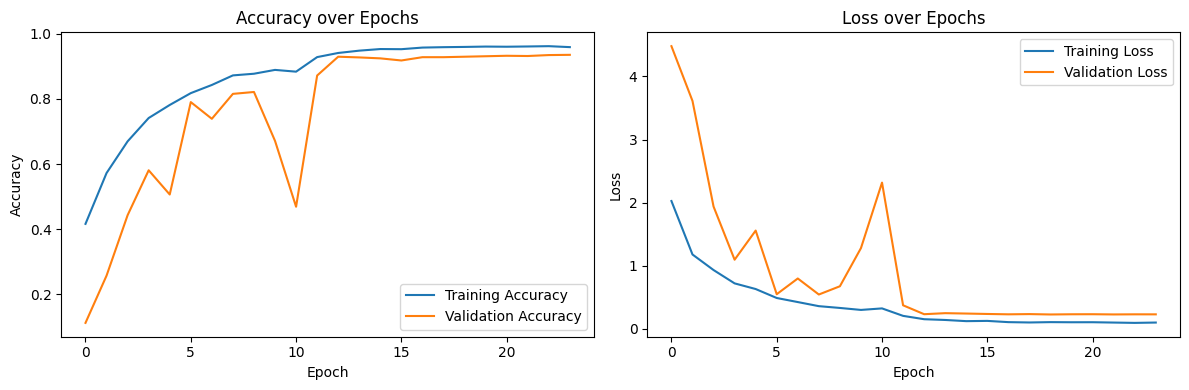

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_skin_cancer_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint, reduce_lr],
    verbose=1
)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

Test Accuracy: 0.9365
Test Loss: 0.2011
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step

Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.82      1.00      0.90       138
      basal cell carcinoma       0.98      0.94      0.96       138
            dermatofibroma       1.00      1.00      1.00       139
                  melanoma       0.95      0.75      0.84       139
                     nevus       0.93      0.75      0.83       139
           not_skin_cancer       1.00      1.00      1.00       139
pigmented benign keratosis       0.92      0.95      0.94       139
      seborrheic keratosis       0.85      1.00      0.92       138
   squamous cell carcinoma       0.99      0.98      0.98       139
           vascular lesion       0.97      1.00      0.99       138

                  accuracy                           0.94      1386
                 macro avg       0.94      0.94      0.94      1386
         

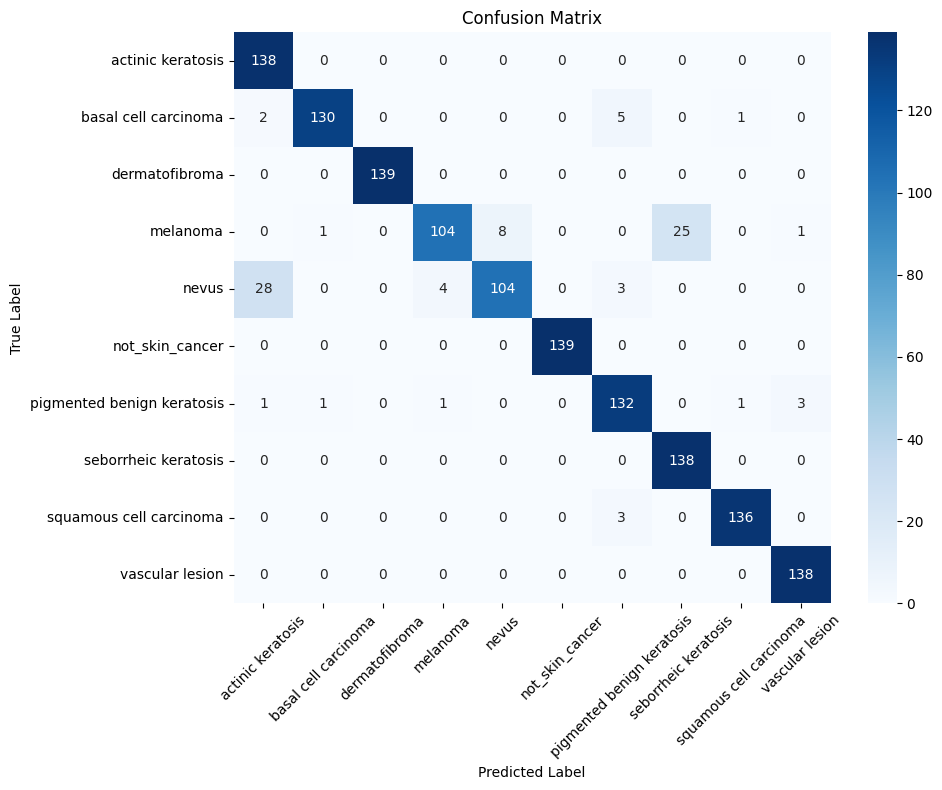

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Load the best model
from tensorflow.keras.models import load_model
best_model = load_model('best_skin_cancer_model.h5')

# Evaluate on test set
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(label_map.values())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [23]:
# Load our best model (custom CNN)
best_model = load_model('best_skin_cancer_model.h5')

# Convert to TensorFlow Lite for mobile deployment
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

# Apply quantization to reduce size and improve inference speed
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Optional: Further reduce size with float16 quantization
converter.target_spec.supported_types = [tf.float16]

# Convert the model
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('sagalyze_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Check model size
model_size = os.path.getsize('sagalyze_model.tflite') / (1024 * 1024)  # MB
print(f"Model Size: {model_size:.2f} MB")

# Test inference time
import time
interpreter = tf.lite.Interpreter(model_path='sagalyze_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test with a sample image
sample_image = np.expand_dims(x_test[0], axis=0).astype('float32')
interpreter.set_tensor(input_details[0]['index'], sample_image)

# Measure inference time
start_time = time.time()
interpreter.invoke()
inference_time = time.time() - start_time

print(f"Inference Time: {inference_time:.4f} seconds")

# Get prediction
prediction = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(prediction)
print(f"Predicted Class: {predicted_class} ({label_map[predicted_class]})")
print(f"Actual Class: {np.argmax(y_test[0])} ({label_map[np.argmax(y_test[0])]})")

# Verify model performance on test set
# Fix the evaluation function - convert input to FLOAT32
def evaluate_tflite_model(interpreter, x_test, y_test):
    correct_predictions = 0
    total_predictions = len(x_test)

    for i in range(total_predictions):
        # Convert input to FLOAT32 and add batch dimension
        input_data = np.expand_dims(x_test[i], axis=0).astype(np.float32)

        # Set input
        interpreter.set_tensor(input_details[0]['index'], input_data)

        # Run inference
        interpreter.invoke()

        # Get prediction
        prediction = interpreter.get_tensor(output_details[0]['index'])
        predicted_class = np.argmax(prediction)
        actual_class = np.argmax(y_test[i])

        if predicted_class == actual_class:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy

# Evaluate the TFLite model
tflite_accuracy = evaluate_tflite_model(interpreter, x_test, y_test)
print(f"TFLite Model Accuracy: {tflite_accuracy:.4f}")

# Compare with original model
print(f"Original Model Accuracy: {test_acc:.4f}")
print(f"Accuracy Difference: {abs(test_acc - tflite_accuracy):.4f}")

Saved artifact at '/tmp/tmplfnlqgw8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 100, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136787796801872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136787796793616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136787796795920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136787796794768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136787796800528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136787796802448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136787796801488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136787796798608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136791684554320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136791684549904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136791684554128

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


TFLite Model Accuracy: 0.9365
Original Model Accuracy: 0.9365
Accuracy Difference: 0.0000


Comparing uploaded images with training data...

Training Data Characteristics (Sample):
Training Brightness: 168.33 ± 11.66
Training Contrast: 31.81 ± 6.15
Training Edge Density: 0.0700 ± 0.0661

Testing preprocessing on training data...
True Class: dermatofibroma
Predicted Class: dermatofibroma
Confidence: 99.98%


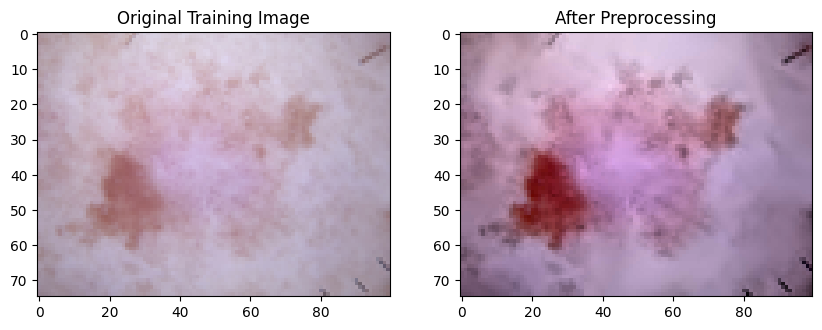

In [24]:
import cv2
import numpy as np
from PIL import Image as PILImage
import ipywidgets as widgets
from IPython.display import display, Image, HTML
import io
import tensorflow as tf
# First, let's analyze what makes these images different
def advanced_image_analysis(img):
    """Perform advanced analysis of image characteristics."""
    # Convert to numpy array
    img_array = np.array(img)

    # Basic stats
    brightness = np.mean(img_array)
    contrast = np.std(img_array)

    # Color distribution
    r_hist = np.histogram(img_array[:,:,0], bins=256)[0]
    g_hist = np.histogram(img_array[:,:,1], bins=256)[0]
    b_hist = np.histogram(img_array[:,:,2], bins=256)[0]

    # Edge density (as a proxy for image sharpness/detail)
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    edge_density = np.sum(edges > 0) / edges.size

    # Texture analysis using Local Binary Pattern
    try:
        from skimage.feature import local_binary_pattern
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        lbp_hist, _ = np.histogram(lbp, bins=n_points + 2)
        lbp_hist = lbp_hist / lbp_hist.sum()  # Normalize
    except:
        lbp_hist = np.zeros(10)

    return {
        'brightness': brightness,
        'contrast': contrast,
        'edge_density': edge_density,
        'r_hist': r_hist,
        'g_hist': g_hist,
        'b_hist': b_hist,
        'lbp_hist': lbp_hist,
        'size': img.size
    }

# Compare with training data
print("Comparing uploaded images with training data...")
print("\nTraining Data Characteristics (Sample):")
train_sample = x_train[:100]  # Sample of training data

# Calculate training data stats
train_brightness = []
train_contrast = []
train_edge_density = []

for i in range(0, len(train_sample), 10):
    img_array = (train_sample[i] * 255).astype(np.uint8)
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)

    train_brightness.append(np.mean(img_array))
    train_contrast.append(np.std(img_array))

    edges = cv2.Canny(gray, 50, 150)
    train_edge_density.append(np.sum(edges > 0) / edges.size)

print(f"Training Brightness: {np.mean(train_brightness):.2f} ± {np.std(train_brightness):.2f}")
print(f"Training Contrast: {np.mean(train_contrast):.2f} ± {np.std(train_contrast):.2f}")
print(f"Training Edge Density: {np.mean(train_edge_density):.4f} ± {np.std(train_edge_density):.4f}")

# Now let's create a more sophisticated preprocessing pipeline
def advanced_preprocessing(img):
    """Advanced preprocessing to match training data characteristics."""
    # Convert to RGB if needed
    if img.mode == 'RGBA':
        background = PILImage.new("RGB", img.size, (255, 255, 255))
        background.paste(img, mask=img.split()[3])
        img = background

    # Convert to numpy array
    img_array = np.array(img)

    # 1. Resize to standard size while maintaining aspect ratio
    h, w = img_array.shape[:2]
    target_ratio = 100 / 75  # Model input ratio

    if w / h > target_ratio:
        # Image is wider - crop width
        new_w = int(h * target_ratio)
        left = (w - new_w) // 2
        img_array = img_array[:, left:left+new_w, :]
    else:
        # Image is taller - crop height
        new_h = int(w / target_ratio)
        top = (h - new_h) // 2
        img_array = img_array[top:top+new_h, :, :]

    # 2. Apply histogram matching to training data
    # This is more sophisticated than simple brightness/contrast adjustment
    try:
        from skimage.exposure import match_histograms

        # Use a reference image from training data
        reference = (x_train[0] * 255).astype(np.uint8)
        img_array = match_histograms(img_array, reference, multichannel=True)
    except:
        # Fallback to simple normalization
        img_array = cv2.normalize(img_array, None, 0, 255, cv2.NORM_MINMAX)

    # 3. Apply mild denoising if needed
    img_array = cv2.fastNlMeansDenoisingColored(img_array, None, 3, 3, 7, 21)

    # 4. Convert back to PIL and resize to model input
    img = PILImage.fromarray(img_array)
    img = img.resize((100, 75))

    return img

# Update the prediction function
def enhanced_predict(img):
    """Enhanced prediction with advanced preprocessing."""
    # Apply advanced preprocessing
    processed_img = advanced_preprocessing(img)

    # Convert to array and normalize
    img_array = np.array(processed_img) / 255.0
    img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

    # Make prediction
    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])

    return prediction, processed_img

# Test with a sample from training data to verify preprocessing works
print("\nTesting preprocessing on training data...")
sample_idx = 0
train_img = (x_train[sample_idx] * 255).astype(np.uint8)
train_pil = PILImage.fromarray(train_img)

# Process and predict
prediction, processed_img = enhanced_predict(train_pil)
predicted_class = np.argmax(prediction)
true_class = np.argmax(y_train[sample_idx])

print(f"True Class: {label_map[true_class]}")
print(f"Predicted Class: {label_map[predicted_class]}")
print(f"Confidence: {np.max(prediction):.2%}")

# Display the processed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_img)
plt.title('Original Training Image')
plt.subplot(1, 2, 2)
plt.imshow(processed_img)
plt.title('After Preprocessing')
plt.show()

In [28]:
from PIL import Image
import numpy as np

IMG_HEIGHT = 75
IMG_WIDTH = 100

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.convert("RGB")                # force 3 channels
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    img = np.array(img).astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)       # (1, H, W, 3)
    return img


In [29]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path='sagalyze_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [54]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def predict_image(image_path, label_map, top_k=3):
    # -------- Show Image --------
    img_display = Image.open(image_path).convert("RGB")

    plt.figure(figsize=(4, 4))
    plt.imshow(img_display)
    plt.axis("off")
    plt.title("Input Image")
    plt.show()

    # -------- Preprocess for model --------
    img = img_display.resize((IMG_WIDTH, IMG_HEIGHT))
    img = np.array(img).astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)

    # -------- Run TFLite inference --------
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()

    output = interpreter.get_tensor(output_details[0]['index'])[0]

    # -------- Top-K Predictions --------
    top_indices = np.argsort(output)[::-1][:top_k]

    print("Top Predictions:")
    for rank, idx in enumerate(top_indices, start=1):
        confidence = output[idx]

        if confidence > 0.85:
            level = "High"
        elif confidence > 0.70:
            level = "Moderate"
        else:
            level = "Low"

        print(f"{rank}. {label_map[idx]} → {confidence:.4f} ({level} confidence)")

    #return top_indices, output[top_indices]


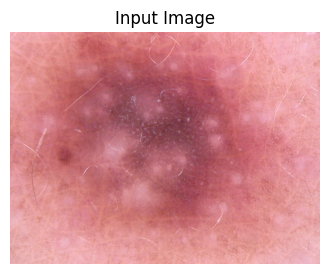

Top Predictions:
1. dermatofibroma → 1.0000 (High confidence)
2. pigmented benign keratosis → 0.0000 (Low confidence)
3. basal cell carcinoma → 0.0000 (Low confidence)


In [60]:
image_path = "/content/drive/MyDrive/MedicalAI/sample_image/download.jpg"

predict_image(image_path, label_map)
